The goal of this notebook is to look for performance regression in Pythran before its release. To do so, several cython kernels have been collected on the World Wide Web, mostly from stackoverflow and blogs.

For each kernel, a Numpy version, a Cython version and a Pythran version (which aims to be equal to the Numpy version, with an additional ``#pythran export``) are benchmarked. If Pythran can rip the same performance level as Cython from the Numpy -like code, then it's ok for the release!

# Disclaimer

Benchmarking is a difficult task. This notebook does not aim to be a reference comparison between Cython and Pythran. So many factors are involved: the developper proficiency in Cython, Numpy and Pythran, the underlying C compiler, or C++ compiler (we made sure they were using the same gcc version, at least), their respective compilation flags (they are different, but both use  ``-O2`` and **not** ``-ffast-math``), the Pythran/Cython version… So take it as it is: a way to make sure the Pythran developpers did not miss an obvious optimization opportunity, or introduced a performance regression. No other conclusions should be made without great care.

# Setup

The happy few:

In [1]:
import numpy as np
%load_ext Cython
%load_ext pythran.magic

The benchmarking routine:

In [2]:
import timeit
import pandas
from collections import OrderedDict
%matplotlib inline
def run_bench(functions, sizes, args_factory):
    global function, args  # to please timeit
    scores = pandas.DataFrame(data=0, columns=functions.keys(), index=sizes)
    for size in sizes:
        size = int(size)
        for name, function in functions.items():
            args = args_factory(size)
            result = %timeit -q -o function(*args)
            scores.loc[size, name] = result.best
    return scores

# cos_norm

*source: [stackoverflow](http://stackoverflow.com/questions/32258905/optimization-and-speedup-of-a-mathematical-function-in-python)*

This kernel tests classical element wise operations *à la* Numpy.

In [3]:
def np_cos_norm(a, b):
    val = np.sum(1. - np.cos(a-b))
    return np.sqrt(val / 2. / a.shape[0])

In [4]:
%%cython

cimport cython
cimport numpy as np

cdef extern from "math.h":
    double cos(double x) nogil
    double sqrt(double x) nogil

def cython_cos_norm(a, b):
    return cos_norm_impl(a, b)

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cdef double cos_norm_impl(double[::1] a, double[::1] b) nogil:
    cdef double res = 0., val
    cdef int m = a.shape[0]
    # XXX: shape of b not checked
    cdef int j

    for j in range(m):
        val = a[j] - b[j]
        res += 1. - cos(val)
    res /= 2.*m

    return sqrt(res)

In [5]:
%%pythran

#pythran export pythran_cos_norm(float[], float[])
import numpy as np
def pythran_cos_norm(a, b):
    val = np.sum(1. - np.cos(a-b))
    return np.sqrt(val / 2. / a.shape[0])

## Timings (lower is better)

In [6]:
cos_norms = OrderedDict([('numpy', np_cos_norm),
                         ('cython', cython_cos_norm),
                         ('pythran', pythran_cos_norm)])
sizes = 1e3, 1e4, 1e5, 1e6
def args_factory(size):
    return (np.random.random(size).astype('float64'),
            np.random.random(size).astype('float64'))
scores = run_bench(cos_norms, sizes, args_factory)

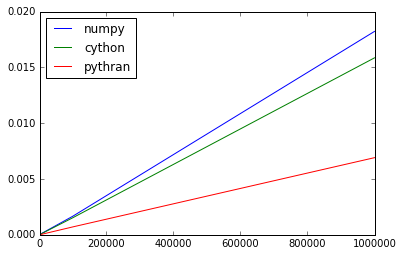

In [7]:
scores.plot()

That's unexpected! The reason why we go faster than Cython is the ``cos`` routine, as we use [nt2](http://nt2.numscale.com/) implementation that proves to be very efficient (it has a few shortpaths). Switching back to ``std::cos`` gives the same execution time has Cython.

# Grayscott

*source: [stackoverflow](http://stackoverflow.com/questions/26823312/numba-or-cython-acceleration-in-reaction-diffusion-algorithm)*

This kernel tests complex array interactions: slices, element-wise operations, everything into a regular loop!

In [8]:
def np_grayscott(counts, Du, Dv, F, k):
    n = 300
    U = np.zeros((n+2,n+2), dtype=np.float_)
    V = np.zeros((n+2,n+2), dtype=np.float_)
    u, v = U[1:-1,1:-1], V[1:-1,1:-1]

    r = 20
    u[:] = 1.0
    U[n/2-r:n/2+r,n/2-r:n/2+r] = 0.50
    V[n/2-r:n/2+r,n/2-r:n/2+r] = 0.25
    u += 0.15*np.random.random((n,n))
    v += 0.15*np.random.random((n,n))

    for i in range(counts):
        Lu = (                 U[0:-2,1:-1] +
              U[1:-1,0:-2] - 4*U[1:-1,1:-1] + U[1:-1,2:] +
                               U[2:  ,1:-1] )
        Lv = (                 V[0:-2,1:-1] +
              V[1:-1,0:-2] - 4*V[1:-1,1:-1] + V[1:-1,2:] +
                               V[2:  ,1:-1] )
        uvv = u*v*v
        u += Du*Lu - uvv + F*(1 - u)
        v += Dv*Lv + uvv - (F + k)*v

    return V

In [9]:
%%cython

cimport cython
import numpy as np
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef cython_grayscott(int counts, double Du, double Dv, double F, double k):
    cdef int n = 300
    cdef np.ndarray U = np.zeros((n+2,n+2), dtype=np.float_)
    cdef np.ndarray V = np.zeros((n+2,n+2), dtype=np.float_)
    cdef np.ndarray u = U[1:-1,1:-1]
    cdef np.ndarray v = V[1:-1,1:-1]

    cdef int r = 20
    u[:] = 1.0
    U[n/2-r:n/2+r,n/2-r:n/2+r] = 0.50
    V[n/2-r:n/2+r,n/2-r:n/2+r] = 0.25
    u += 0.15*np.random.random((n,n))
    v += 0.15*np.random.random((n,n))

    cdef np.ndarray Lu = np.zeros_like(u)
    cdef np.ndarray Lv = np.zeros_like(v)
    cdef int i, c, r1, c1, r2, c2
    cdef double uvv

    cdef double[:, ::1] bU = U
    cdef double[:, ::1] bV = V
    cdef double[:, ::1] bLu = Lu
    cdef double[:, ::1] bLv = Lv

    for i in range(counts):
        for r in range(n):
            r1 = r + 1
            r2 = r + 2
            for c in range(n):
                c1 = c + 1
                c2 = c + 2
                bLu[r,c] = bU[r1,c2] + bU[r1,c] + bU[r2,c1] + bU[r,c1] - 4*bU[r1,c1]
                bLv[r,c] = bV[r1,c2] + bV[r1,c] + bV[r2,c1] + bV[r,c1] - 4*bV[r1,c1]

        for r in range(n):
            r1 = r + 1
            for c in range(n):
                c1 = c + 1
                uvv = bU[r1,c1]*bV[r1,c1]*bV[r1,c1]
                bU[r1,c1] += Du*bLu[r,c] - uvv + F*(1 - bU[r1,c1])
                bV[r1,c1] += Dv*bLv[r,c] + uvv - (F + k)*bV[r1,c1]

    return V

In [10]:
%%pythran

#pythran export pythran_grayscott(int, float, float, float, float)
import numpy as np
def pythran_grayscott(counts, Du, Dv, F, k):
    n = 300
    U = np.zeros((n+2,n+2), dtype=np.float_)
    V = np.zeros((n+2,n+2), dtype=np.float_)
    u, v = U[1:-1,1:-1], V[1:-1,1:-1]

    r = 20
    u[:] = 1.0
    U[n/2-r:n/2+r,n/2-r:n/2+r] = 0.50
    V[n/2-r:n/2+r,n/2-r:n/2+r] = 0.25
    u += 0.15*np.random.random((n,n))
    v += 0.15*np.random.random((n,n))

    for i in range(counts):
        Lu = (                 U[0:-2,1:-1] +
              U[1:-1,0:-2] - 4*U[1:-1,1:-1] + U[1:-1,2:] +
                               U[2:  ,1:-1] )
        Lv = (                 V[0:-2,1:-1] +
              V[1:-1,0:-2] - 4*V[1:-1,1:-1] + V[1:-1,2:] +
                               V[2:  ,1:-1] )
        uvv = u*v*v
        u += Du*Lu - uvv + F*(1 - u)
        v += Dv*Lv + uvv - (F + k)*v

    return V

## Timings (lower is better)

In [11]:
grayscotts = OrderedDict([('numpy', np_grayscott),
                          ('cython', cython_grayscott),
                          ('pythran', pythran_grayscott)])
sizes = 1e1, 5e1, 1e2, 5e2, 1e3
def args_factory(size):
    return size, 0.16, 0.08, 0.04, 0.06
scores = run_bench(grayscotts, sizes, args_factory)

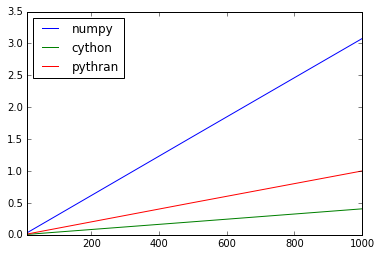

In [12]:
scores.plot()

We have a small issue there. Need to investigate! Still a decent speedup though.

# clip

*source: [pythran issue](https://github.com/serge-sans-paille/pythran/issues/433)*

This kernel tests conditionnal assignment (through ``np.where``) and array of complex numbers.

In [13]:
def np_clip(z, _max):
    return np.where(np.abs(z) > _max, z/np.abs(z) * _max, z)

In [14]:
%%cython

cimport cython
import numpy as np
cimport numpy as np

cdef extern from "complex.h":
    double cabs(double complex x) nogil

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef cython_clip (double complex[::1] z, double _max):
    cdef np.ndarray out_ = np.empty_like(z)
    cdef int n = len(z), i
    cdef double complex[::1] out = out_
    for i in range (n):
        if cabs(z[i]) > _max:
            out[i] = z[i]/cabs(z[i]) * _max
        else:
            out[i] = z[i]

    return out

In [15]:
%%pythran

#pythran export pythran_clip(complex128[], float64)
import numpy as np
def pythran_clip(z, _max):
    return np.where(np.abs(z) > _max, z/np.abs(z) * _max, z)

## Timings (lower is better)

In [16]:
clips = OrderedDict([('numpy', np_clip),
                     ('cython', cython_clip),
                     ('pythran', pythran_clip)])
sizes = 1e2, 1e3, 1e4, 1e5, 1e6
def args_factory(size):
    return np.arange(size, dtype=complex) * complex(1,1), size/2
scores = run_bench(clips, sizes, args_factory)

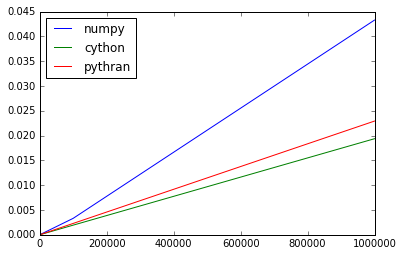

In [17]:
scores.plot()

Nice! Brest! Slightly worse than Cython, but we could improve this by implementing common subexpression elimination at the array level.

# Pariwise distance

*sources: [jakevdp blog](http://jakevdp.github.io/blog/2012/08/24/numba-vs-cython/) and
[Anaconda blog](https://anaconda.org/tonyfast/numbacythonredux/notebook)*

This kernel tests Numpy's broadcasting.

In [18]:
def np_pairwise(X):
    return np.sqrt(((X[:, None, :] - X) ** 2).sum(-1))

In [19]:
%%cython

import numpy as np
cimport cython
from libc.math cimport sqrt

@cython.boundscheck(False)
@cython.wraparound(False)
def cython_pairwise(double[:, ::1] X):
    cdef int M = X.shape[0]
    cdef int N = X.shape[1]
    cdef double tmp, d
    cdef double[:, ::1] D = np.empty((M, M), dtype=np.float64)
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = sqrt(d)
    return np.asarray(D)

In [20]:
%%pythran

#pythran export pythran_pairwise(float64 [][])
import numpy as np
def pythran_pairwise(X):
    return np.sqrt(((X[:, None, :] - X) ** 2).sum(-1))

## Timings

In [21]:
pairwises = OrderedDict([('numpy', np_pairwise),
                         ('cython', cython_pairwise),
                         ('pythran', pythran_pairwise)])
sizes = 0.5e2, 1e2, 2.5e2, 5e2
def args_factory(size):
    return np.random.random((size, size)),
scores = run_bench(pairwises, sizes, args_factory)

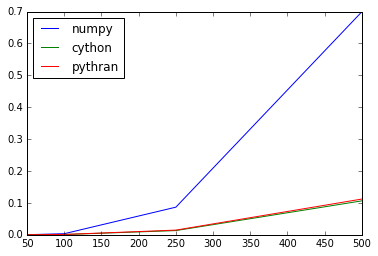

In [22]:
scores.plot()

Wooo! Being able to compile this expression down to something that matches Cython's generated code is an achivement :-)

# lu factorization

*source: [jfp blog](https://www.ibm.com/developerworks/community/blogs/jfp/entry/A_Comparison_Of_C_Julia_Python_Numba_Cython_Scipy_and_BLAS_on_LU_Factorization)*

This kernel tests interaction between Numpy arrays, slices and regular loops.

In [23]:
def np_det_by_lu(y, x):
    y[0] = 1.

    N = x.shape[0]
    with np.errstate(invalid='ignore'):
        for k in range(N):
            y[0] *= x[k,k]
            xk = x[k]
            for i in range(k+1, N):
                xi = x[i]
                xi[k] /= xk[k]
                xi[k+1:] -= xi[k] * xk[k+1:]



In [24]:
%%cython

import cython

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef cython_det_by_lu(double[:] y, double[:,:] x):
    y[0] = 1.

    cdef int N = x.shape[0]
    cdef int i,j,k

    for k in range(N):
        y[0] *= x[k,k]
        for i in range(k+1, N):
            x[i,k] /= x[k,k]
            for j in range(k+1, N):
                x[i,j] -= x[i,k] * x[k,j]



In [25]:
%%pythran
#pythran export pythran_det_by_lu(float64 [:], float64[:,:])
def pythran_det_by_lu(y, x):
    y[0] = 1.
    N = x.shape[0]
    
    for k in range(N):
        y[0] *= x[k,k]
        xk = x[k]
        for i in range(k+1, N):
            xi = x[i]
            xi[k] /= xk[k]
            xi[k+1:] -= xi[k] * xk[k+1:]

## Timings

In [26]:
det_by_lus = OrderedDict([('numpy', np_det_by_lu),
                          ('cython', cython_det_by_lu),
                          ('pythran', pythran_det_by_lu)])
sizes = 1e2, 2.5e2, 5e2; 7.5e2, 1e3
def args_factory(size):
    return np.random.random(size), np.random.random((size, size))
scores = run_bench(det_by_lus, sizes, args_factory)

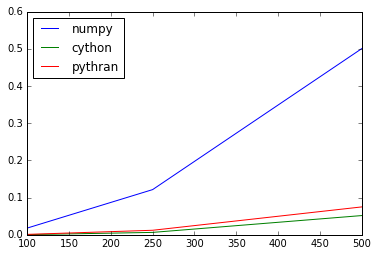

In [27]:
scores.plot()

On par with Cython, checked! Note that both Cython and Pythran kernel don't handle errors as Numpy kernel does…

# Conclusion

Ready for release? Looks like everything is ok, we're most of the time not far from cython, while keeping the Numpy high-level calls ``\o/``

# Acknowledgments

Thanks a lot to the authors of the cited blogs / stackoverflow threads for providing stimulating code samples. I did improve my cython king-fu a lot thanks to you!

(by order of apparition)

- [NoExit](http://stackoverflow.com/users/5273154/noexit)
- [ev-br](http://stackoverflow.com/users/143765/ev-br)
- [snotna](http://stackoverflow.com/users/4231346/snotna)
- [HYRY](http://stackoverflow.com/users/772649/hyry)
- [ndbecker](https://github.com/nbecker)
- [pbrunet](https://github.com/pbrunet)
- [Jake VanderPlas](http://staff.washington.edu/jakevdp/)
- [tonyfast](https://anaconda.org/tonyfast)
- [Jean-Francois Puget](https://www.ibm.com/developerworks/community/profiles/html/profileView.do?userid=2700028FGP)